In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import data.constants as dconstants
import model.constants as mconstants
from data.build import load_data_from_configuration, load_base_data_from_configuration
from model.build import make_model
from data.util import data_get_num_attributes, data_get_num_classes
from train import train_model
from data.transform import PerturbationTransform
from torch_geometric.loader import DataLoader
import umap
from openTSNE import TSNE
from model.density import get_density_model
from model.prediction import SOFT_PREDICTIONS
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import seed

In [4]:
import logging 
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [5]:
import tempfile

spectrum_fn = tempfile.NamedTemporaryFile(suffix='.pkl')
spectrum_fn.name

'/tmp/tmpqc_y5_iw.pkl'

In [6]:
data_cfg = configuration.DataConfiguration(
                        dataset=dconstants.CORA_FULL, 
                        train_portion=20, test_portion_fixed=0.2,
                        ood_type = dconstants.PERTURBATION,
                        setting = dconstants.TRANSDUCTIVE,
                        drop_train_vertices_portion = 0.1,
                        preprocessing='none'
                        )

In [7]:
spectral_norm_cfg = {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 10.0,
    }

reconstruction_cfg = {
        'loss_weight' : 1.0, # Use for BCE-based  and mconstants.ENERGY
        #'loss_weight' : 10.0, # Use higher values for distance based mconstants.TRIPLET
        'sample' : True,
        'num_samples' : 1000,
        'reconstruction_type' : mconstants.ENERGY,
        'margin_constrastive_loss' : 0.0,
    }

model_cfg = configuration.ModelConfiguration(
        model_type=mconstants.GCN_LINEAR_CLASSIFICATION,
        hidden_sizes=[64,], 
        use_bias=True, 
        activation='leaky_relu', 
        leaky_relu_slope=0.01,
        freeze_residual_projection=False, 
        use_spectral_norm_on_last_layer=True,
        use_residual_on_last_layer=False,
        self_loop_fill_value=1.0, 
        cached=True,
        **spectral_norm_cfg,
        # residual=True,
        # reconstruction = reconstruction_cfg,
        )
if not model_cfg.use_spectral_norm:
    model_cfg.use_spectral_norm_on_last_layer = False

training_cfg = configuration.TrainingConfiguration(
        max_epochs=1000, # 1000, 
        learning_rate=0.001, 
        early_stopping={
            'monitor' : 'val_loss',
            'mode' : 'min',
            'patience' : 50,
            'min_delta' : 1e-2,
        }, 
        gpus=1, 
        suppress_stdout=False, 
        weight_decay=1e-3,
        )
logging_cfg = configuration.LoggingConfiguration(
    log_weight_matrix_spectrum_every = 1,
    log_weight_matrix_spectrum_to_file = spectrum_fn.name,
)

cfg = configuration.ExperimentConfiguration(model=model_cfg, data=data_cfg, training=training_cfg, logging=logging_cfg)

In [8]:
cfg.model

ModelConfiguration(hidden_sizes=[64], linear_classification=False, weight_scale=10.0, use_spectral_norm=True, model_type='gcn_linear_classification', use_bias=True, activation='leaky_relu', leaky_relu_slope=0.01, residual=True, residual_pre_activation=True, freeze_residual_projection=False, dropout=0.0, drop_edge=0.0, use_spectral_norm_on_last_layer=True, use_residual_on_last_layer=False, cached=True, self_loop_fill_value=1.0, reconstruction=ReconstructionConfiguration(loss_weight=0.0, sample=True, num_samples=100, seed=1337, reconstruction_type='autoencoder', cached=True, margin_constrastive_loss=0.0), feature_reconstruction=FeatureReconstructionConfiguration(loss_weight=0.0, loss='l2', mirror_encoder=True, activation_on_last_layer=False, log_metrics_every=1, num_samples=-1, seed=1337), gat=None, appnp=None, bgcn=None, laplace=None, input_distance=None, gdk=None)

In [9]:
configuration.update_with_default_configuration(cfg)

INFO:root:Set configuration value data.base_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning', 'Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance']
INFO:root:Set configuration value data.corpus_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intell

In [10]:
# cfg.data.preprocessing = 'bag_of_words'

In [11]:
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[cfg.run.initialization_idx]))
model_seed = next(model_seed_generator)
data_split_seed = seed.data_split_seeds()[cfg.run.split_idx]

In [12]:

cfg.registry.split_seed = data_split_seed
cfg.registry.model_seed = model_seed

In [13]:
print(data_split_seed, model_seed)

2612666288 1952926171


In [14]:

datasets, _ = load_data_from_configuration(cfg.data, cfg.registry.split_seed)

INFO:root:Data Loading - Loaded adjacency matrix.
INFO:root:Data Loading - Built attribute matrix.


In [15]:
datasets[dconstants.TRAIN][0].x.size()

torch.Size([2810, 8710])

In [16]:
datasets[dconstants.TRAIN][0].x.norm(dim=-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [17]:
pl.seed_everything(cfg.registry.model_seed)
model = make_model(cfg, data_get_num_attributes(datasets[dconstants.TRAIN][0]), 
                data_get_num_classes(datasets[dconstants.TRAIN][0])) 

Global seed set to 1952926171


In [18]:
model

SemiSupervisedNodeClassification(
  (backbone): GCNLinearClassification(
    (convs): ModuleList(
      (0): ResidualBlock(
        (conv): GCNConv(8710, 64)
        (act): LeakyReLU(negative_slope=0.01)
        (input_projection): LinearWithSpectralNormaliatzion(
          (linear): ParametrizedLinear(
            in_features=8710, out_features=64, bias=True
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): _SpectralNorm()
              )
            )
          )
        )
      )
      (1): ResidualBlock(
        (conv): GCNConv(64, 64)
        (act): LeakyReLU(negative_slope=0.01)
      )
    )
    (head): BasicBlock(
      (conv): LinearWithSpectralNormaliatzion(
        (linear): ParametrizedLinear(
          in_features=64, out_features=7, bias=True
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _SpectralNorm()
            )
          )
        )
      )
    )
  )

In [19]:
data_loaders = {
            name : DataLoader(data, batch_size=1, shuffle=False) for name, data in datasets.items()
        }

In [20]:
cfg.run.use_pretrained_model = False

In [21]:
cfg.run.use_pretrained_model

False

In [22]:
if cfg.training.gpus and not torch.cuda.is_available():
    cfg.training.gpus = 0
    print(f'Requested gpus but not available.')

Requested gpus but not available.


In [23]:
model = train_model(model, cfg, '~', data_loaders, logger=None).eval().cpu()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type                    | Params
-----------------------------------------------------
0 | backbone | GCNLinearClassification | 1.1 M 
-----------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.478     Total estimated model params size (MB)
Global seed set to 1952926171
INFO:root:Paths ['/nfs/students/fuchsgru/model_registry/2014447551.ckpt'] were overwritten with /nfs/homedirs/fuchsgru/MastersThesis/~/epoch=5-step=5.ckpt


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_accuracy': 0.7142857313156128,
 'val_cross_entropy': 0.937092125415802,
 'val_loss': 0.937092125415802}
--------------------------------------------------------------------------------


In [24]:
model.clear_and_disable_cache()

INFO:root:<class 'model.nn.GCNConv'> disabled cache.
INFO:root:<class 'model.nn.GCNConv'> disabled cache.


In [25]:
import pickle
with open(spectrum_fn.name, 'rb') as f:
    spectrum = pickle.load(f)

In [26]:
spectrum.keys()

dict_keys(['backbone.convs.0.conv.lin.parametrizations.weight.original', 'backbone.convs.0.input_projection.linear.parametrizations.weight.original', 'backbone.convs.1.conv.lin.parametrizations.weight.original', 'backbone.head.conv.linear.parametrizations.weight.original'])

In [27]:
conv0_weight_name = [k for k in spectrum.keys() if 'conv' in k and '0' in k and 'lin' in k and not 'input_projection' in k]
if len(conv0_weight_name) > 1:
    raise ValueError(f'Found multiple candidates for conv0 weight {conv0_weight_name}')
conv0_weight_name = conv0_weight_name[0]
conv0_weight_name

'backbone.convs.0.conv.lin.parametrizations.weight.original'

In [28]:
from plot.histogram_evolution import plot_heatmap2d, plot_histogram_evolution

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:xlabel='Epoch', ylabel='Singular Value'>)

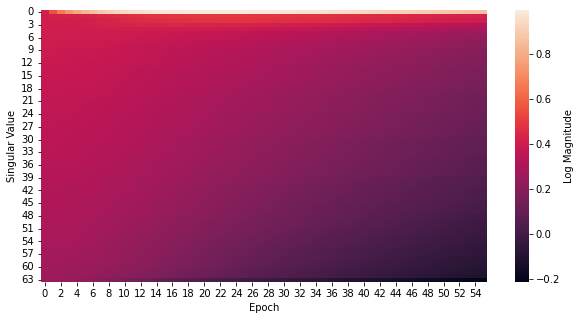

In [29]:
plot_heatmap2d(spectrum[conv0_weight_name], cbar_label='Magnitude', value_name='Singular Value',
                time_name='Epoch', log_scale=True, time_interval = cfg.logging.log_weight_matrix_spectrum_every)

(<Figure size 720x360 with 2 Axes>,
 <AxesSubplot:xlabel='Epoch', ylabel='Singular Value'>)

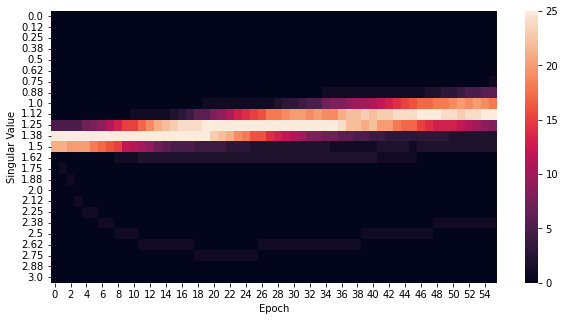

In [30]:
plot_histogram_evolution(np.array(spectrum[conv0_weight_name]), value_name='Singular Value',
                time_name='Epoch', time_interval = cfg.logging.log_weight_matrix_spectrum_every)

In [31]:
if cfg.data.ood_type == dconstants.PERTURBATION:
    data_ood = PerturbationTransform(noise_type='bernoulli', p=0.5)(datasets[dconstants.OOD_VAL][0])
elif cfg.data.ood_type == dconstants.LEFT_OUT_CLASSES:
    data_ood = datasets[dconstants.OOD_VAL][0]
data_train = datasets[dconstants.TRAIN][0]
data_val = datasets[dconstants.VAL][0]

In [32]:
data_val.cpu().edge_index.device

device(type='cpu')

In [33]:
with torch.no_grad():
    prediction_val = model(data_val.cpu())
    prediction_train = model(data_train.cpu())
    prediction_ood = model(data_ood.cpu())

In [34]:
features_ood = prediction_ood.get_features(-2)
features_train = prediction_train.get_features(-2)
features_val = prediction_train.get_features(-2)
print(features_ood.size(), features_train.size(), torch.allclose(features_train, features_val))

torch.Size([2810, 64]) torch.Size([2810, 64]) True


In [35]:
density = get_density_model('GaussianPerClass', covariance='diag')

In [36]:
# features_val[data_ood.mask].size(), data_ood.y[data_ood.mask].size()

soft_train = torch.zeros_like(prediction_train.get_logits())


soft_train[torch.arange(soft_train.size(0))[data_train.mask], data_train.y[data_train.mask]] = 1.0




# soft_val = prediction_val.get(SOFT_PREDICTIONS)
density.fit(features_train[data_train.mask], soft_train[data_train.mask], features_val[data_val.mask], soft_train[data_val.mask])

In [37]:
density_ood = density(features_ood)

auroc = roc_auc_score(
        (~data_ood.is_out_of_distribution[data_ood.mask]).long().cpu().numpy(),
        density_ood[data_ood.mask].cpu().numpy(),
)
precision, recall, _ = precision_recall_curve(
        (~data_ood.is_out_of_distribution[data_ood.mask]).long().cpu().numpy(),
        density_ood[data_ood.mask].cpu().numpy(),
)
aucpr = auc(recall, precision)
print(f'AUROC density: {auroc:.4f}, AUCPR density: {aucpr:.4f}')

AUROC density: 0.9899, AUCPR density: 0.9936


In [38]:
distances = torch.cdist(features_ood, features_train[data_train.mask], p=2)
distances_sorted, _ = torch.sort(distances, dim=-1)
distances_sorted = distances_sorted[:, :5]

distance_proxy = distances_sorted.mean(1)
auroc = roc_auc_score(
        (~data_ood.is_out_of_distribution[data_ood.mask]).long().cpu().numpy(),
        -distance_proxy[data_ood.mask].cpu().numpy(),
)
precision, recall, _ = precision_recall_curve(
        (~data_ood.is_out_of_distribution[data_ood.mask]).long().cpu().numpy(),
        -distance_proxy[data_ood.mask].cpu().numpy(),
)
print(f'AUROC distance: {auroc:.4f}, AUCPR distance: {auc(recall, precision):.4f}')


AUROC distance: 0.9315, AUCPR distance: 0.9510


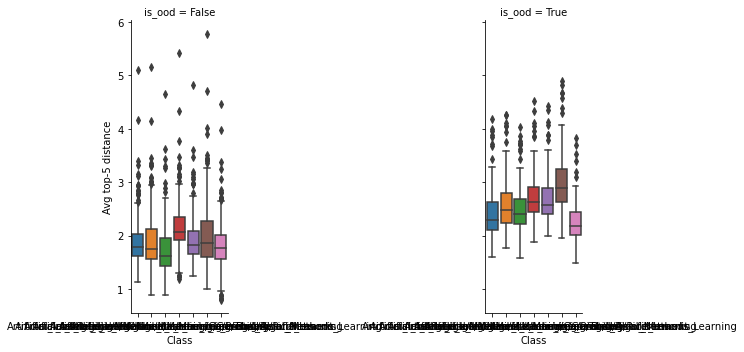

In [39]:
k = 5
# per class
distances_pc = []
idx_to_label = {idx : label for label, idx in data_ood.label_to_idx.items()}
for cl in range(soft_train.size(1)):
    distances = torch.cdist(features_ood, features_train[(data_train.y == cl) & data_train.mask])
    distances_sorted, _ = torch.sort(distances, dim=-1)
    distances_sorted = distances_sorted[:, :k]
    distances_pc.append(distances_sorted.mean(1))
distances_pc = torch.stack(distances_pc, dim=-1)

df_pc = pd.DataFrame({
    'is_ood' : data_ood.is_out_of_distribution[data_ood.mask],
} | {
    idx_to_label[cl] : distances_pc[data_ood.mask, cl]for cl in range(distances_pc.size(1))
})

df_pc = df_pc.melt(id_vars='is_ood', var_name='Class', value_name=f'Avg top-{k} distance')
sns.catplot(data = df_pc, x = 'Class', y = f'Avg top-{k} distance', col='is_ood', kind='box')

In [40]:
from sklearn.decomposition import PCA

In [41]:
pca = PCA(n_components=2)
features_emb = pca.fit_transform(torch.cat([
    features_train[data_train.mask], features_ood[data_ood.mask]], dim=0).numpy())
features_train_emb = features_emb[:features_train[data_train.mask].size(0)]
features_val_emb = features_emb[features_train[data_train.mask].size(0):]

In [42]:
pca.explained_variance_ratio_

array([0.4067132 , 0.10035144], dtype=float32)

In [43]:
is_ood = data_ood.is_out_of_distribution[data_ood.mask]

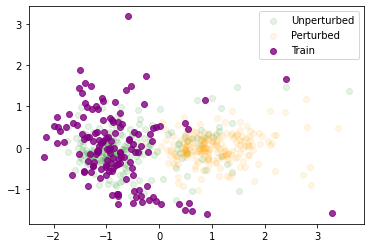

In [44]:


plt.scatter(features_val_emb[:, 0][~is_ood], features_val_emb[:, 1][~is_ood], label='Unperturbed', alpha=0.1, color='green')
plt.scatter(features_val_emb[:, 0][is_ood], features_val_emb[:, 1][is_ood], label='Perturbed', alpha=0.1, color='orange')
plt.scatter(features_train_emb[:, 0], features_train_emb[:, 1], label='Train', alpha=0.8, color='purple')
plt.legend()

In [45]:
logits_val = prediction_val.get_logits()
logits_ood = prediction_ood.get_logits()
logits_train = prediction_train.get_logits()

In [46]:
tsne = TSNE(random_state=1337)

tsne_emb = tsne.fit(torch.cat([
    logits_train[data_train.mask], logits_ood[data_ood.mask]
], dim=0).numpy())

logits_train_emb = tsne_emb[:logits_train[data_train.mask].size(0)]
logits_val_emb = tsne_emb[logits_train[data_train.mask].size(0):]


INFO:openTSNE.tsne:Precomputed initialization provided. Ignoring initalization-related parameters.
INFO:openTSNE.tsne:Automatically determined negative gradient method `bh`
INFO:openTSNE.tsne:Automatically determined negative gradient method `bh`


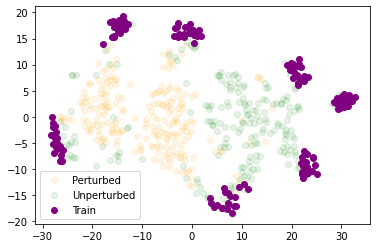

In [47]:

plt.scatter(logits_val_emb[:, 0][is_ood], logits_val_emb[:, 1][is_ood], label='Perturbed', alpha=0.1, color='orange')
plt.scatter(logits_val_emb[:, 0][~is_ood], logits_val_emb[:, 1][~is_ood], label='Unperturbed', alpha=0.1, color='green')
plt.scatter(logits_train_emb[:, 0], logits_train_emb[:, 1], label='Train', alpha=1.0, color='purple')
plt.legend()

In [48]:
lpca = PCA(n_components=2, random_state=1337)
logits_pemb = lpca.fit_transform(torch.cat([
    logits_train[data_train.mask], logits_ood[data_ood.mask]
], dim=0).numpy())
logits_train_pemb = logits_pemb[:features_train[data_train.mask].size(0)]
logits_val_pemb = logits_pemb[features_train[data_train.mask].size(0):]

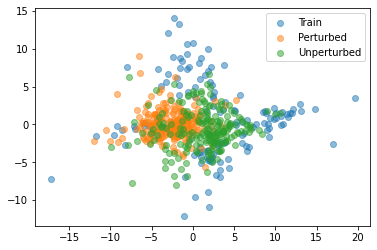

In [49]:
plt.scatter(logits_train_pemb[:, 0], logits_train_pemb[:, 1], label='Train', alpha=0.5)
plt.scatter(logits_val_pemb[:, 0][is_ood], logits_val_pemb[:, 1][is_ood], label='Perturbed', alpha=0.5)
plt.scatter(logits_val_pemb[:, 0][~is_ood], logits_val_pemb[:, 1][~is_ood], label='Unperturbed', alpha=0.5)
plt.legend()

## Investigate the weight matrices of the first convolution

In [50]:
conv = model.backbone.convs[0]
conv

ResidualBlock(
  (conv): GCNConv(8710, 64)
  (act): LeakyReLU(negative_slope=0.01)
  (input_projection): LinearWithSpectralNormaliatzion(
    (linear): ParametrizedLinear(
      in_features=8710, out_features=64, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
  )
)

In [51]:
# SVD on the input projection
W_proj = conv.input_projection.linear.weight.detach().numpy()

In [52]:
W_conv = conv.conv.lin.weight.detach().numpy()

In [53]:
u_proj, s_proj, vh_proj = np.linalg.svd(W_proj, full_matrices=False)

In [54]:
', '.join([f'{sv:.1f}' for sv in s_proj])

'10.0, 5.3, 5.0, 4.9, 4.7, 4.5, 4.4, 4.2, 4.1, 4.1, 4.0, 4.0, 4.0, 4.0, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.7, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.4, 3.4, 3.4, 3.4'

In [55]:
u_conv, s_conv, vh_conv = np.linalg.svd(W_conv, full_matrices=False)

In [56]:
', '.join([f'{sv:.1f}' for sv in s_conv])

'10.0, 6.6, 6.5, 6.4, 6.4, 6.3, 6.3, 6.3, 6.3, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.2, 6.1, 6.1, 6.1, 6.1, 6.1, 6.1, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.9, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.7, 5.6, 5.6, 5.6, 5.6, 5.6, 5.5, 5.5, 5.5, 5.5, 5.5, 5.4, 5.4, 5.3'

In [57]:


x_ood = data_ood.x[data_ood.mask & data_ood.is_out_of_distribution].numpy()
y_ood = data_ood.y[data_ood.mask & data_ood.is_out_of_distribution].numpy()
x_id = data_ood.x[data_ood.mask & ~data_ood.is_out_of_distribution].numpy()
y_id = data_ood.y[data_ood.mask & ~data_ood.is_out_of_distribution].numpy()

# Group by class
x_ood = x_ood[np.argsort(y_ood)]
x_id = x_id[np.argsort(y_id)]


In [58]:
x_ood.shape, x_id.shape

((220, 8710), (199, 8710))

Text(0.5, 1.0, 'Perturbed')

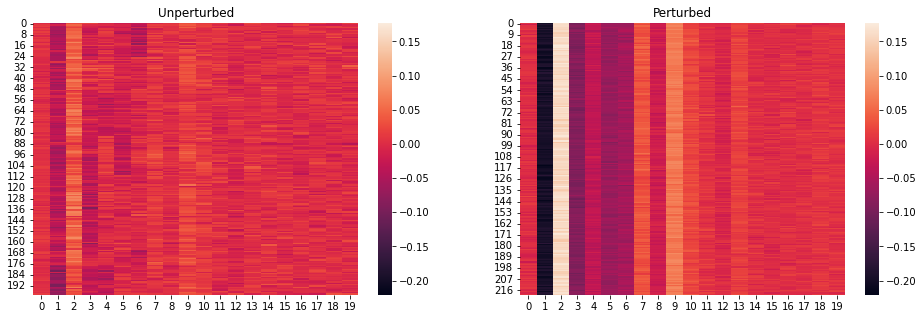

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
vmin = min((x_id @ vh_proj.T).min(), (x_ood @ vh_proj.T).min())
vmax = max((x_id @ vh_proj.T).max(), (x_ood @ vh_proj.T).max())

sns.heatmap((x_id @ vh_proj.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[0])
axs[0].set_title('Unperturbed')
sns.heatmap((x_ood @ vh_proj.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[1])
axs[1].set_title('Perturbed')

Text(0.5, 1.0, 'Perturbed')

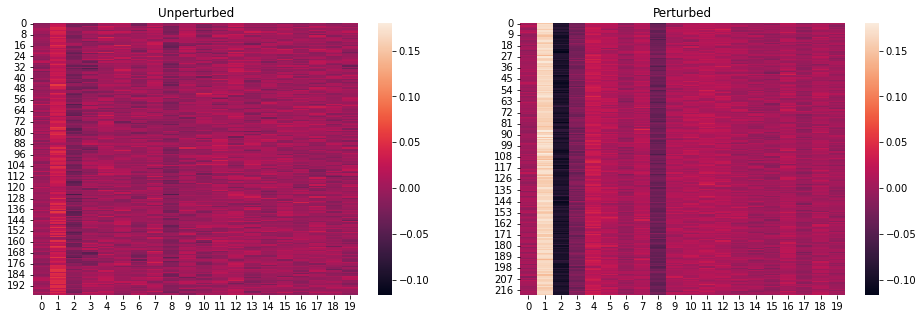

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
vmin = min((x_id @ vh_conv.T).min(), (x_ood @ vh_conv.T).min())
vmax = max((x_id @ vh_conv.T).max(), (x_ood @ vh_conv.T).max())
sns.heatmap((x_id @ vh_conv.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[0])
axs[0].set_title('Unperturbed')
sns.heatmap((x_ood @ vh_conv.T)[:, :20], vmin=vmin, vmax=vmax, ax=axs[1])
axs[1].set_title('Perturbed')

Text(0.5, 1.0, 'Distribution of weights for inputs Proj')

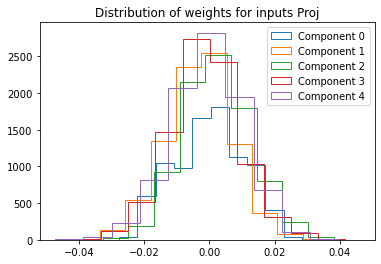

In [61]:
components = range(5)
fig, ax = plt.subplots()
for c in components:
    ax.hist(vh_proj[c], histtype='step', label='Component ' + str(c))
ax.legend()
ax.set_title('Distribution of weights for inputs Proj')

Text(0.5, 1.0, 'Distribution of weights for inputs Conv Weight')

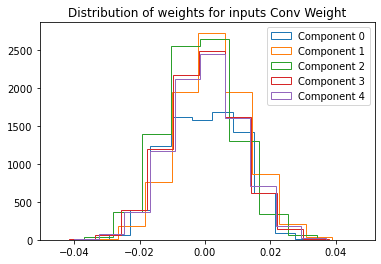

In [62]:
components = range(5)
fig, ax = plt.subplots()
for c in components:
    ax.hist(vh_conv[c], histtype='step',  label='Component ' + str(c))
ax.legend()
ax.set_title('Distribution of weights for inputs Conv Weight')

Text(0.5, 1.0, 'Fraction Non Zero OOD')

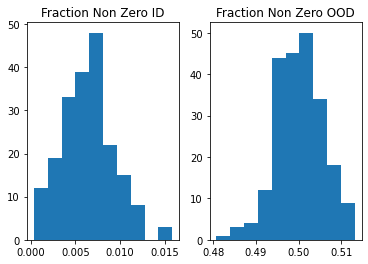

In [63]:
fig, axs = plt.subplots(1, 2)
axs[0].hist((x_id > 0).sum(1) / x_ood.shape[1])
axs[0].set_title('Fraction Non Zero ID')
axs[1].hist((x_ood > 0).sum(1) / x_ood.shape[1])
axs[1].set_title('Fraction Non Zero OOD')

In [64]:
#data_raw = np.load('./data/raw/cora_full.npz', allow_pickle=True)
#print(list(data_raw.keys()))
#idx_to_feature = data_raw['idx_to_attr'].item()

idx_to_feature = {int(idx) : feature for feature, idx in load_base_data_from_configuration(cfg.data).feature_to_idx.items()}

INFO:root:Data Loading - Loaded adjacency matrix.
INFO:root:Data Loading - Built attribute matrix.


In [65]:
print('Strongest correlating words Proj Weight')
most_relevant = np.argsort(-np.abs(vh_proj), axis=1)
for i in range(10):
    most_relevant_i = most_relevant[i, :5]
    weights = vh_proj[i, :][most_relevant_i]
    words = [idx_to_feature[j] for j in most_relevant_i]
    
    #print(','.join(f'{word} ({weight:.2f})' for weight, word in zip(weights, words)))
    
    print(', '.join(words))
    #print(f'Component {i} : ' + '\t' + ', '.join(words))
    #print('\t' + '\n\t'.join(f'{word} : {weight:.2f}' for weight, word in zip(weights, words)))
    

Strongest correlating words Proj Weight
semistructured, terrain, interior, precondition, rewriting
peak, perform, players, iteration, provided
pacific, partly, starting, classified, relation
scott, temperature, maximizes, financial, community
universitat, differing, predictable, aircraft, runtime
usual, relates, sharply, survey, standards
aspects, repository, dominant, matches, analogy
explanatory, specialize, overcome, wilson, discussing
regardless, identifying, passive, build, lecture
tel, regards, conditioning, controller, precludes


In [66]:
print('Strongest correlating words Conv Weight')
most_relevant = np.argsort(-np.abs(vh_conv), axis=1)
for i in range(10):
    most_relevant_i = most_relevant[i, :5]
    weights = vh_conv[i, :][most_relevant_i]
    words = [idx_to_feature[j] for j in most_relevant_i]
    print(', '.join(words))
    #print(f'Component {i} : ' + '\t' + ', '.join(words))
    #print('\t' + '\n\t'.join(f'{word} : {weight:.2f}' for weight, word in zip(weights, words)))
    

Strongest correlating words Conv Weight
aborted, authorization, physically, fewest, earliest
explains, rr, vlsi, reconstructions, port
tactical, dijkstra, im, kernels, bsd
greatly, george, led, nonetheless, entirely
performs, uniform, gas, hut, mn
digraph, datasets, wasted, bivariate, possesses
target, interference, storing, domain, growing
58, completion, theme, composed, cosine
actual, inferencing, unbounded, destination, support
enforcing, let, corrections, created, proposes
